In [94]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import mca
import matplotlib.pyplot as plt
from collections import Counter

In [136]:
class Compare:
    def __init__ (self, collections):
        self.collections = collections
        if not isinstance(self.collections, list):
            self.collections = [self.collections]
        if len(self.collections) == 2:
            self.response = self.two_venn(self.collections)
        elif len(self.collections) == 3:
            self.three_venn(self.collections)
        elif len(self.collections) >3:
            self.ca(self.collections)
    # Venn diagram of two collections
    def union (self, sets_list):
        return set().union(*sets_list)
    def two_venn (self, collections):
        return  (venn2([set(x) for x in collections]))
    def three_venn (self, collections):
        return  (venn3([set(x) for x in collections]))
    def ca(self, collections):
        dd = self.union(collections)
        d = []
        for y in collections:
            d.append({x: x in y for x in dd})
        df = pd.DataFrame(d, index=["col_1", "col_2", "col_3", "col_4", "col_5"]).T
        counts = mca.mca(df)
        #data = np.array(counts.L, counts.fs_r())
        return(df)
        

In [137]:
collection1 = ["google", "apple", "microsoft", "msn", "napster", "oracle", "amazon", "ibm"]
collection2 = ["google", "pear", "thebeatles", "thepogues", "napster", "apple", "cow"]
collection3 = ["google", "apple", "msn", "skunk", "beaver", "wolf", "cow"]
collection4 = ["apple", "jump", "walk", "run", "saunter", "skunk", "napster"]
collection5 = ["pear", "wolf", "jive", "tango"]

one_collect = [collection1]
two_collect = [collection1, collection2]
three_collect = [collection1, collection2, collection3]
all_collect = [collection1, collection2, collection3, collection4, collection5]

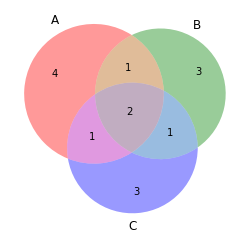

In [134]:

compare = Compare(three_collect)

In [135]:
print (compare.ca(all_collect))

            col_1  col_2  col_3  col_4  col_5
amazon       True  False  False  False  False
apple        True   True   True   True  False
beaver      False  False   True  False  False
cow         False   True   True  False  False
google       True   True   True  False  False
ibm          True  False  False  False  False
jive        False  False  False  False   True
jump        False  False  False   True  False
microsoft    True  False  False  False  False
msn          True  False   True  False  False
napster      True   True  False   True  False
oracle       True  False  False  False  False
pear        False   True  False  False   True
run         False  False  False   True  False
saunter     False  False  False   True  False
skunk       False  False   True   True  False
tango       False  False  False  False   True
thebeatles  False   True  False  False  False
thepogues   False   True  False  False  False
walk        False  False  False   True  False
wolf        False  False   True  F

In [111]:
plt.show()